In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import bernoulli
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
def rbf(x,y,l_squared=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.zeros(dim)
    type_x = x.shape
    type_y = y.shape
    if len(type_x) == len(type_y):
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*l_squared))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*l_squared))
        return vect

In [3]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=0.5, high=2, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-1, high=0., size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

In [4]:
for i in range(2*n_gen):
    random = bernoulli.rvs(p=3/4)
    if random == 1:
        whole_data[i,2] = -1
positive_data = np.zeros((1,3))
unlabeled_data = np.zeros((1,3))
for i in range(n_samples):
    if whole_data[i,2] == 1:
        positive_data = np.vstack((positive_data, whole_data[i,:]))
    else:
        unlabeled_data = np.vstack((unlabeled_data, whole_data[i,:]))

positive_data = np.delete(positive_data,0,0)
unlabeled_data = np.delete(unlabeled_data,0,0)
pu_data = np.vstack((positive_data,unlabeled_data))

In [5]:
output_train = pu_data[:,2]

In [6]:
pu_df = pd.DataFrame(pu_data)
pu_df.columns = ['x1','x2','label']
for i in range(pu_df.shape[0]):
    if output_train[i] == -1:
        output_train[i] = 0
pu_df['label'] = output_train

n_cluster = 3
clustering = KMeans(n_clusters=n_cluster).fit(X=pu_df.to_numpy()[:,:-1])
pu_df['cluster'] = clustering.labels_

list_of_ratio = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_ratio[i] = pu_df[pu_df['cluster'] == i]['label'].sum()/pu_df[pu_df['cluster'] == i].shape[0]

positive_cluster = np.argmax(list_of_ratio)
    
#we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
#instances will be very small compared to the ones of unlabelled instances

list_of_dist = np.zeros(n_cluster)
for i in range(n_cluster):
    list_of_dist[i] = np.linalg.norm(clustering.cluster_centers_[positive_cluster,:] - clustering.cluster_centers_[i,:])

negative_cluster = np.argmax(list_of_dist)

In [7]:
n_samples = pu_df.shape[0]
for i in range(n_samples):
    if pu_df.loc[i,'label'] == 0:
        pu_df.loc[i,'label'] = -1

df_unlab_pop = pu_df[pu_df['label'] == -1]
list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
list_of_pop.columns = ['pop']
list_of_pop['dist'] = list_of_dist #distance to the positive cluster
list_of_pop = list_of_pop.sort_values('dist',ascending=False)
list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])

In [8]:
reliable_positives = pu_df[pu_df['label'] == 1]
n_positives = reliable_positives.shape[0]
last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives)[0][0]
index_ordered_distance = list(list_of_pop.index)
if last_step == 0:
    reliable_negatives = pu_df[pu_df['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
else:
    compteur=0
    reliable_negatives = pu_df[pu_df['cluster'] == negative_cluster]
    reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    while compteur<last_step:
        interm_negatives = pu_df[pu_df['cluster'] == index_ordered_distance[compteur+1]]
        interm_negatives = interm_negatives[interm_negatives['label'] == -1]
        reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
        compteur += 1
    del interm_negatives, compteur

In [9]:
reliable_negatives = reliable_negatives.head(n=n_positives)

In [10]:
train_clf_data = pd.concat([reliable_positives,reliable_negatives])
index_of_labels = list(train_clf_data.index)
unlabelled_data = pu_df.drop(labels=index_of_labels,axis=0)
index_of_unlabelled = list(unlabelled_data.index)
first_step_clf = SVC(gamma=1/8).fit(X=train_clf_data.drop(['label','cluster'],axis=1).to_numpy(),
                          y=train_clf_data['label'].to_numpy())
unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['label','cluster'],axis=1).to_numpy())

In [11]:
gamma = 1
good_ratio = 1/2
max_iter = 1
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data]) #the whole data with positive labels and relabelled
#instances
up_data_np = updated_data.to_numpy()[:,:-3]

In [12]:
gamma = 1
good_ratio = 1/2
max_iter = 100
compteur = 0
train_clf_data['relab'] = train_clf_data['label'].copy()
updated_data = pd.concat([train_clf_data,unlabelled_data]) #the whole data with positive labels and relabelled
#instances
updated_data = updated_data.sort_index()
up_data_np = updated_data.to_numpy()[:,:-3]

In [13]:
while compteur<max_iter:
    compteur += 1
    labels = updated_data['relab'].to_numpy().reshape(1,-1)
    first_row = np.hstack((np.array(0).reshape(1,1),labels))
    
    #computation of omega and the coefficients
    omega = np.zeros((n_samples,n_samples))
    for i in range(n_samples):
        for k in range(i,n_samples):
            omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=4)*labels[0,i]*labels[0,k]
            omega[k,i] = omega[i,k]
        omega[i,i] = 1

    bot_right = omega + gamma*np.eye(n_samples)
    bot = np.hstack((labels.reshape(n_samples,1), bot_right))
    whole_mat = np.vstack((first_row, bot))
    
    del bot_right, bot, first_row

    right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1)))

    coeffs = np.linalg.solve(a=whole_mat,b=right_side)


    alpha = coeffs[1:]

    #once we have the coefficients, we can compute the labels of the unlabelled instances

    to_det_b = np.zeros(n_samples)
    for i in range(n_samples):
        to_det_b[i] = np.sum(alpha*labels*rbf(x=up_data_np,y=up_data_np[i,:],l_squared=4))

    b = np.sort(to_det_b)[int(good_ratio*n_samples)]
    
    check_array = np.zeros(n_samples)
    count_diff = 0
    
    for i in range(n_samples):
        if i in index_of_labels:
            check_array[i] = 1
        else:
            check_array[i] = np.sign(to_det_b[i]-b)
            if check_array[i] != updated_data.loc[i,'relab']:
                count_diff += 1

    if count_diff == 0:
        break
    else:
        updated_data['relab'] = check_array 

In [14]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-5,5,500))
results_plot = np.zeros(500**2)
for i in tqdm(range(500**2)):
    results_plot[i] = np.sum(alpha*check_array*rbf(x=pu_data[:,:-1],y=np.c_[xx.ravel(), yy.ravel()][i,:],l_squared=4))-b
Z = results_plot
Z = Z.reshape(xx.shape)

100%|██████████| 250000/250000 [07:39<00:00, 544.39it/s]


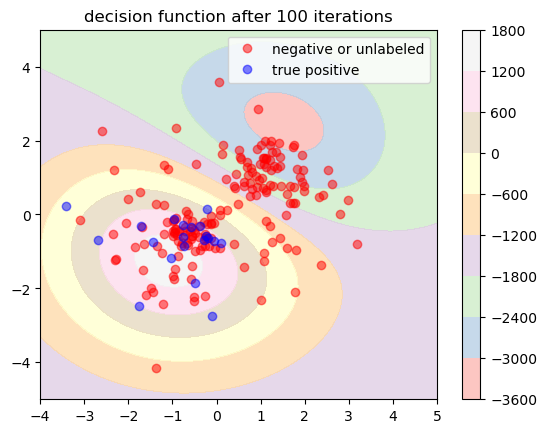

In [21]:
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.Pastel1)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.title('decision function after 100 iterations')
plt.savefig('it_ls_svm_100_it.png')
plt.colorbar()

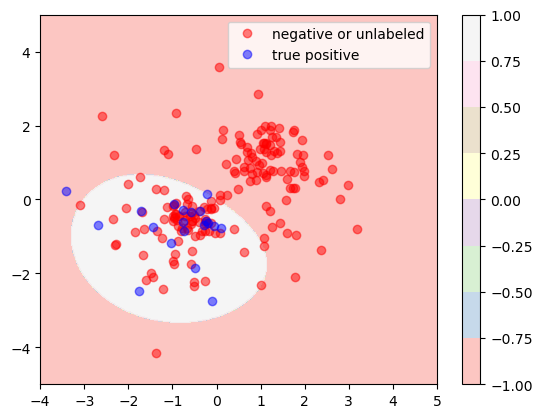

In [16]:
Z_bis = np.sign(Z)
plt.contourf(xx, yy, Z_bis, alpha=0.75, cmap=plt.cm.Pastel1)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()

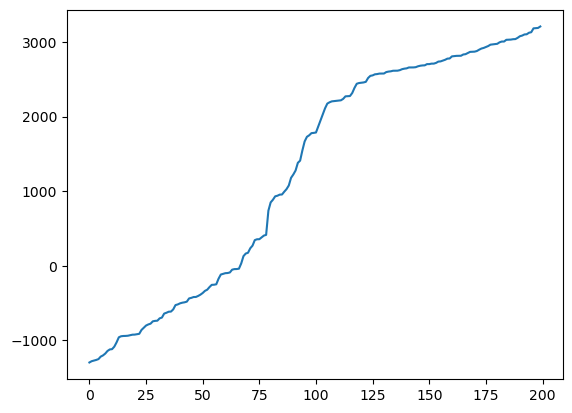

In [17]:
plt.plot(np.sort(to_det_b))

In [18]:
omega[0,159]

-0.26861801490245657

In [19]:
rbf(x=up_data_np[1,:],y=up_data_np[159,:],l_squared=4)*labels[0,1]*labels[0,159]

-0.2848900197750175

In [20]:
updated_data.groupby('relab').count()

,x1,x2,label,cluster
relab,,,,
-1.0,78,78,78,78
0.0,1,1,1,1
1.0,121,121,121,121
